In [1]:
import numpy as np, pandas as pd, scanpy as sc, matplotlib.pyplot as plt, os, celloracle as co
from celloracle.applications import Gradient_calculator, Oracle_development_module

wd = '/ocean/projects/cis240075p/skeshari/igvf/bcell1/male_donor/'
out_path = os.path.join(wd, 'out_data', 'TF_KO_viz')
os.makedirs(f"{out_path}/figures", exist_ok=True)
os.makedirs(f"{out_path}/out_files", exist_ok=True)
os.makedirs(f"{out_path}/scripts", exist_ok=True)
sc.settings.figdir = f"{out_path}/figures"
# visualization settings required to see plots in jupyter notebook
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.rcParams['figure.figsize'] = [6, 4.5]
plt.rcParams["savefig.dpi"] = 300

/ocean/projects/cis240075p/skeshari/.conda/envs/celloracle_env/lib/python3.8/site-packages/loompy/bus_file.py:68: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def twobit_to_dna(twobit: int, size: int) -> str:
/ocean/projects/cis240075p/skeshari/.conda/envs/celloracle_env/lib/python3.8/site-packages/loompy/bus_file.py:85: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for detai

In [2]:
oracle = co.load_hdf5(f"{wd}/out_data/grn_inference/out_files/oracle_fitted.celloracle.oracle")
stream_xdr = pd.read_csv(f"{wd}/out_data/sc_preproc/out_files/stream_xdr.csv", index_col=0)

In [3]:
oracle.adata = oracle.adata[oracle.adata.obs_names.isin(stream_xdr.index)]
oracle.adata.obs['S2_pseudotime'] = stream_xdr.loc[oracle.adata.obs_names, 'S2_pseudotime'].values
oracle.adata.obsm['X_dr'] = stream_xdr.loc[oracle.adata.obs_names, ['x', 'y']].values
oracle.colorandum = stream_xdr.loc[oracle.adata.obs_names, 'leiden'].values
oracle.embedding = oracle.adata.obsm['X_dr']
oracle.adata.obsm['X_umap'] = oracle.adata.obsm['X_dr']

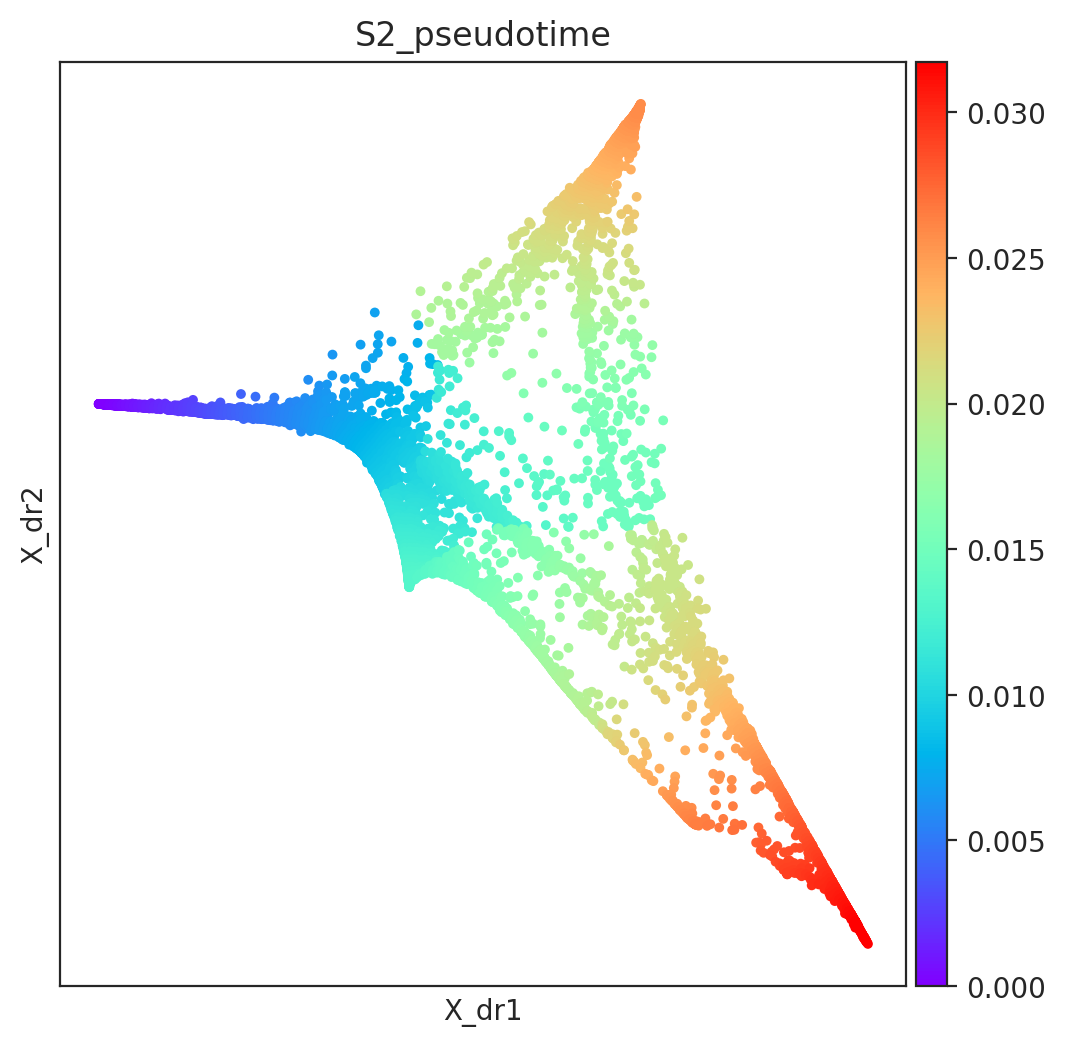

In [4]:
# Visualize pseudotime
fig, ax = plt.subplots(figsize=[6,6])
sc.pl.embedding(adata=oracle.adata, basis= 'X_dr', ax=ax, cmap="rainbow", color=["S2_pseudotime"],s=50)

In [5]:
goi = 'PAX5'
print(f'Simulating perturbation for {goi}', flush=True)
oracle.simulate_shift(perturb_condition={goi: 0.0},n_propagation=2) # If kernal crashes increase the memory limit of jupyter notebook
print(f'Estimating transition probability for {goi}', flush=True)
oracle.estimate_transition_prob(n_neighbors=750, knn_random=True, sampled_fraction=1) # Get transition probability
print(f'Calculating embedding for {goi}', flush=True)
oracle.calculate_embedding_shift(sigma_corr=0.05) # Calculate embedding


Simulating perturbation for PAX5
Estimating transition probability for PAX5
Calculating embedding for PAX5


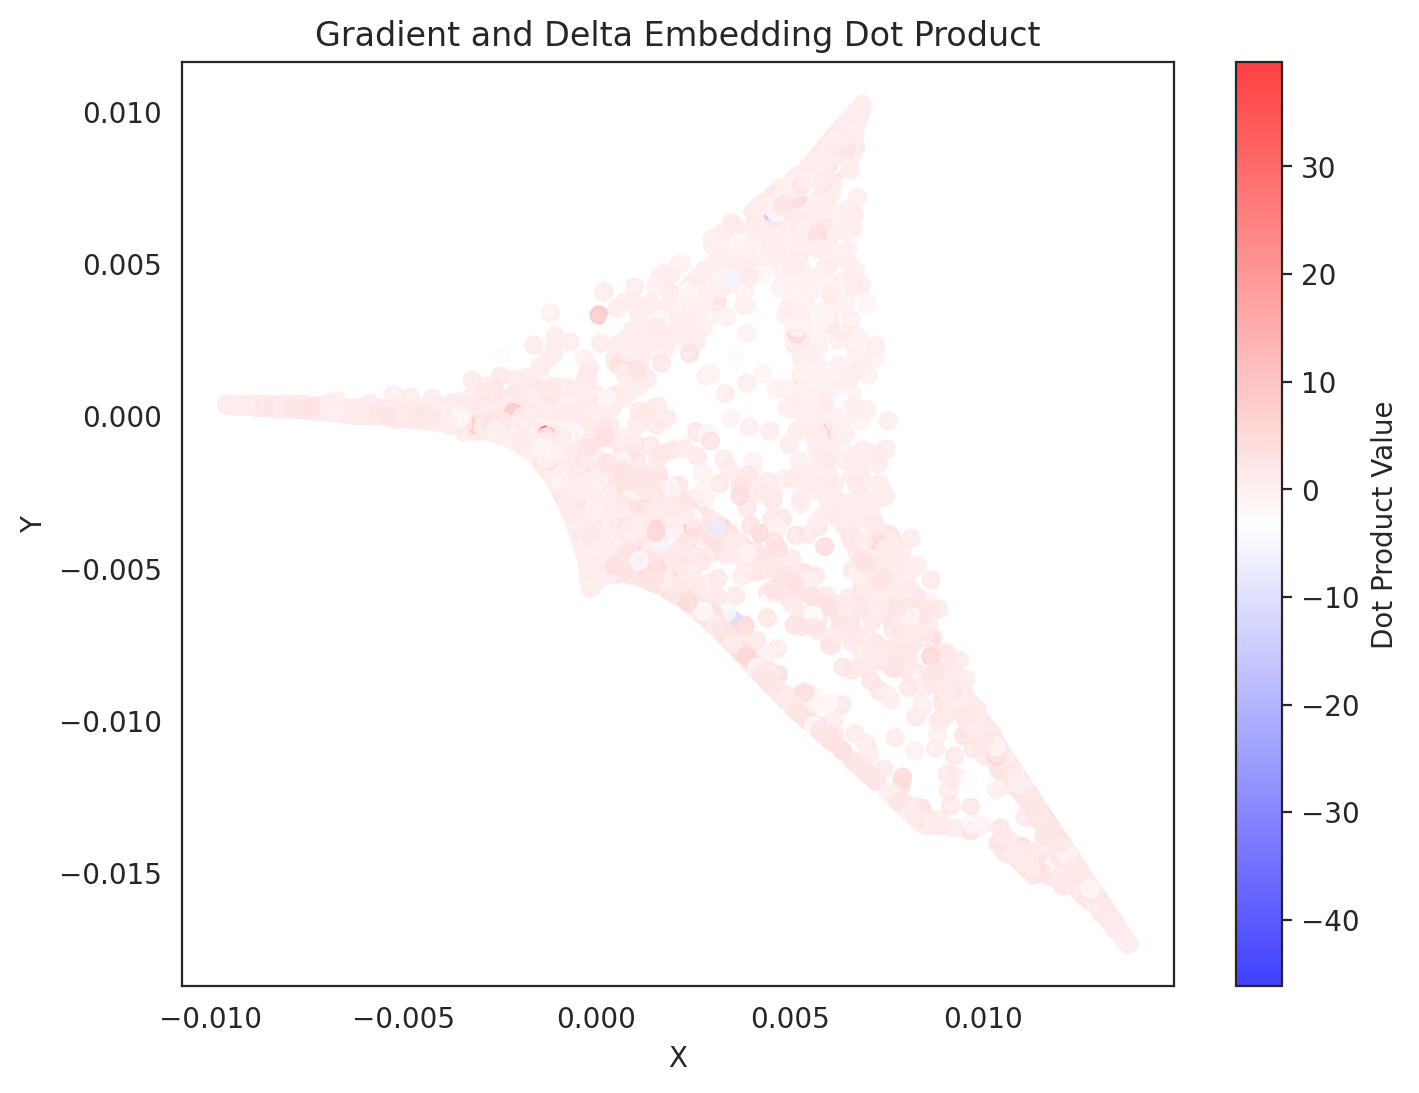

In [44]:
import numpy as np
from scipy.spatial import cKDTree

def get_gradient(value_on_grid):
    points = value_on_grid[['x', 'y']].values
    values = value_on_grid['value'].values

    tree = cKDTree(points)

    gradients = np.zeros((len(points), 2))
    for i, (x, y) in enumerate(points):
        distances, indices = tree.query([x, y], k=5)  # Find nearest neighbors
        neighbor_points = points[indices]
        neighbor_values = values[indices]
        
        dx = (neighbor_values[1] - neighbor_values[0]) / (neighbor_points[1][0] - neighbor_points[0][0] + 1e-10)
        dy = (neighbor_values[3] - neighbor_values[2]) / (neighbor_points[3][1] - neighbor_points[2][1] + 1e-10)
        gradients[i] = [dx, dy]
    
    return gradients

def normalize_gradient(gradient, method="sqrt"):
    """
    Normalize length of 2D vector
    """

    if method == "sqrt":

        size = np.sqrt(np.power(gradient, 2).sum(axis=1))
        size_sq = np.sqrt(size)
        size_sq[size_sq == 0] = 1
        factor = np.repeat(np.expand_dims(size_sq, axis=1), 2, axis=1)

    return gradient / factor

def norm_scale(grad, scale_factor="l2_norm_mean", normalization="sqrt"):

        # # Gradient calculation
        # gradient = get_gradient(value_on_grid)

        if normalization == "sqrt":
            gradient = normalize_gradient(grad, method="sqrt")

        if scale_factor == "l2_norm_mean":
            # divide gradient by the mean of l2 norm.
            l2_norm = np.linalg.norm(gradient, ord=2, axis=1)
            scale_factor = 1 / l2_norm.mean()

        ref_flow = gradient * scale_factor
        return ref_flow

values_on_grid = pd.DataFrame(oracle.embedding, columns=['x', 'y'])
values_on_grid['value'] = oracle.adata.obs['S2_pseudotime'].values
gradient = get_gradient(values_on_grid)

ref_flow = norm_scale(gradient)
delta_embedding = norm_scale(oracle.delta_embedding)

x=oracle.embedding[:, 0]
y=oracle.embedding[:, 1]
dot_product_values = np.einsum('ij,ij->i', ref_flow, delta_embedding)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(x, y, c=dot_product_values, cmap='bwr', alpha=0.75)
plt.colorbar(scatter, label='Dot Product Value')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Gradient and Delta Embedding Dot Product')
plt.show()

<AxesSubplot: title={'center': 'leiden'}, xlabel='UMAP1', ylabel='UMAP2'>

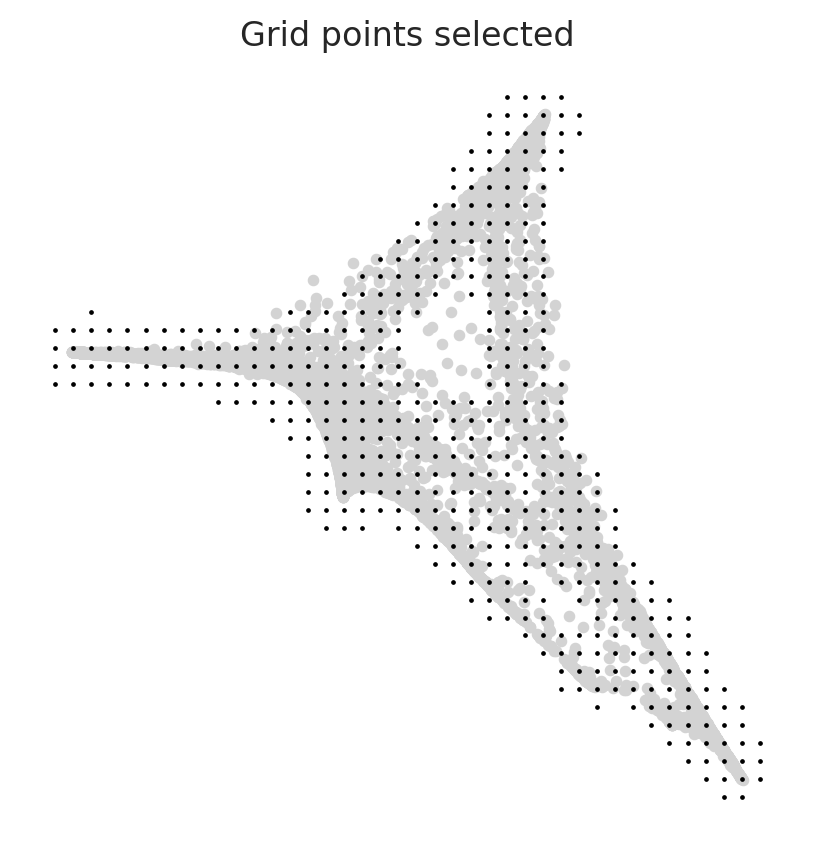

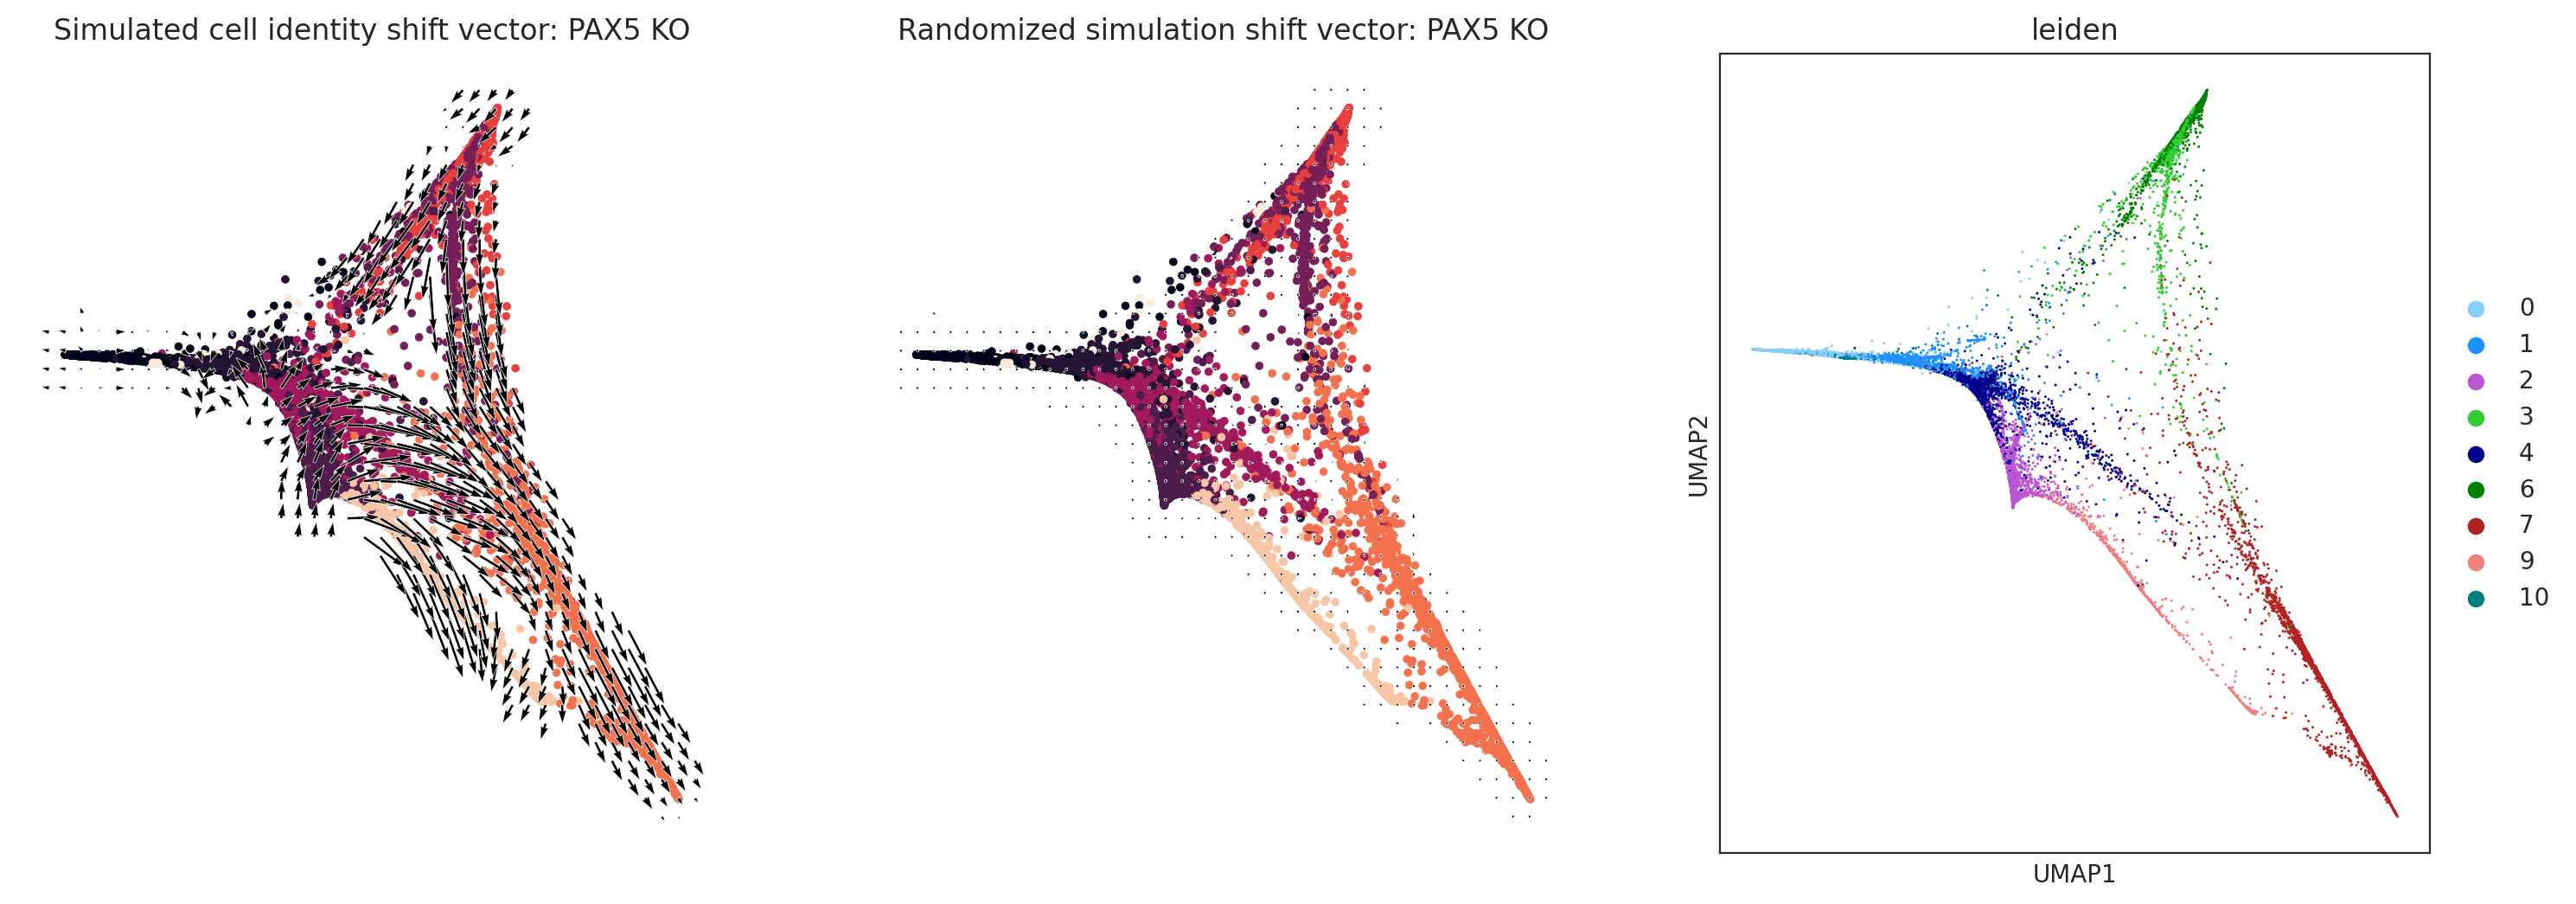

In [7]:
scale_simulation=15
n_grid=40
min_mass=5000

oracle.calculate_p_mass(smooth=0.8, n_grid=n_grid, n_neighbors=750)
oracle.calculate_mass_filter(min_mass=min_mass, plot=True)

fig, ax = plt.subplots(1, 3,  figsize=[18, 6])
oracle.plot_cluster_whole(ax=ax[0], s=10)
ax[0].set_title(f"Simulated cell identity shift vector: {goi} KO")
oracle.plot_simulation_flow_on_grid(scale=scale_simulation, ax=ax[0], show_background=False)
oracle.plot_cluster_whole(ax=ax[1], s=10)
ax[1].set_title(f"Randomized simulation shift vector: {goi} KO")
oracle.plot_simulation_flow_random_on_grid(scale=scale_simulation, ax=ax[1], show_background=False)
ax[2].set_title(f"Clustered cell identity")  
sc.pl.umap(oracle.adata, color=['leiden'], ax=ax[2], show=False)

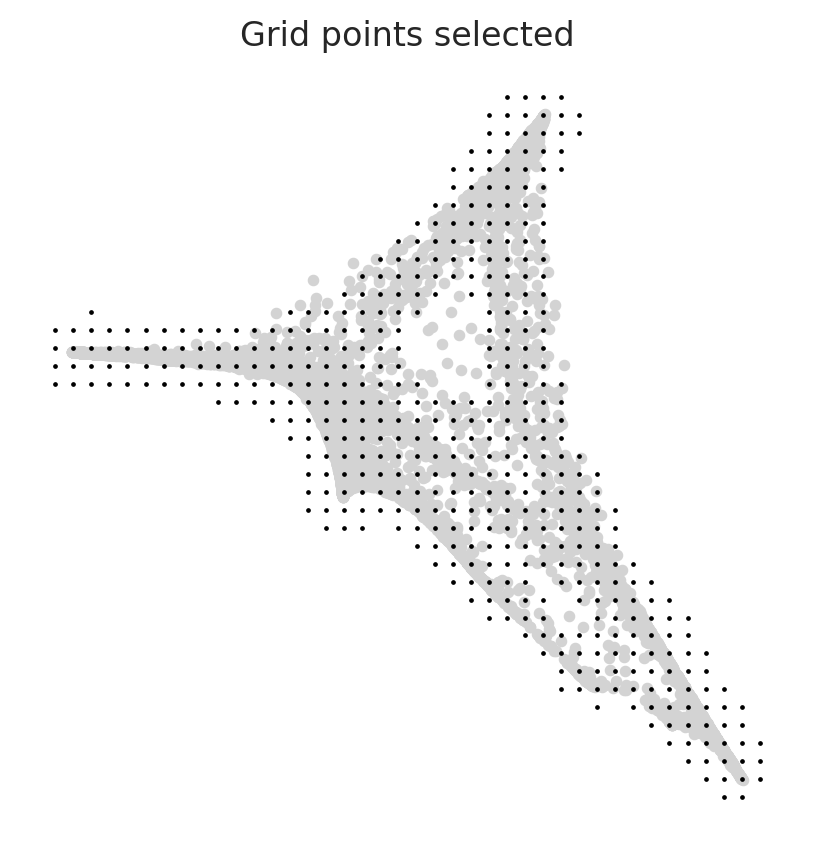

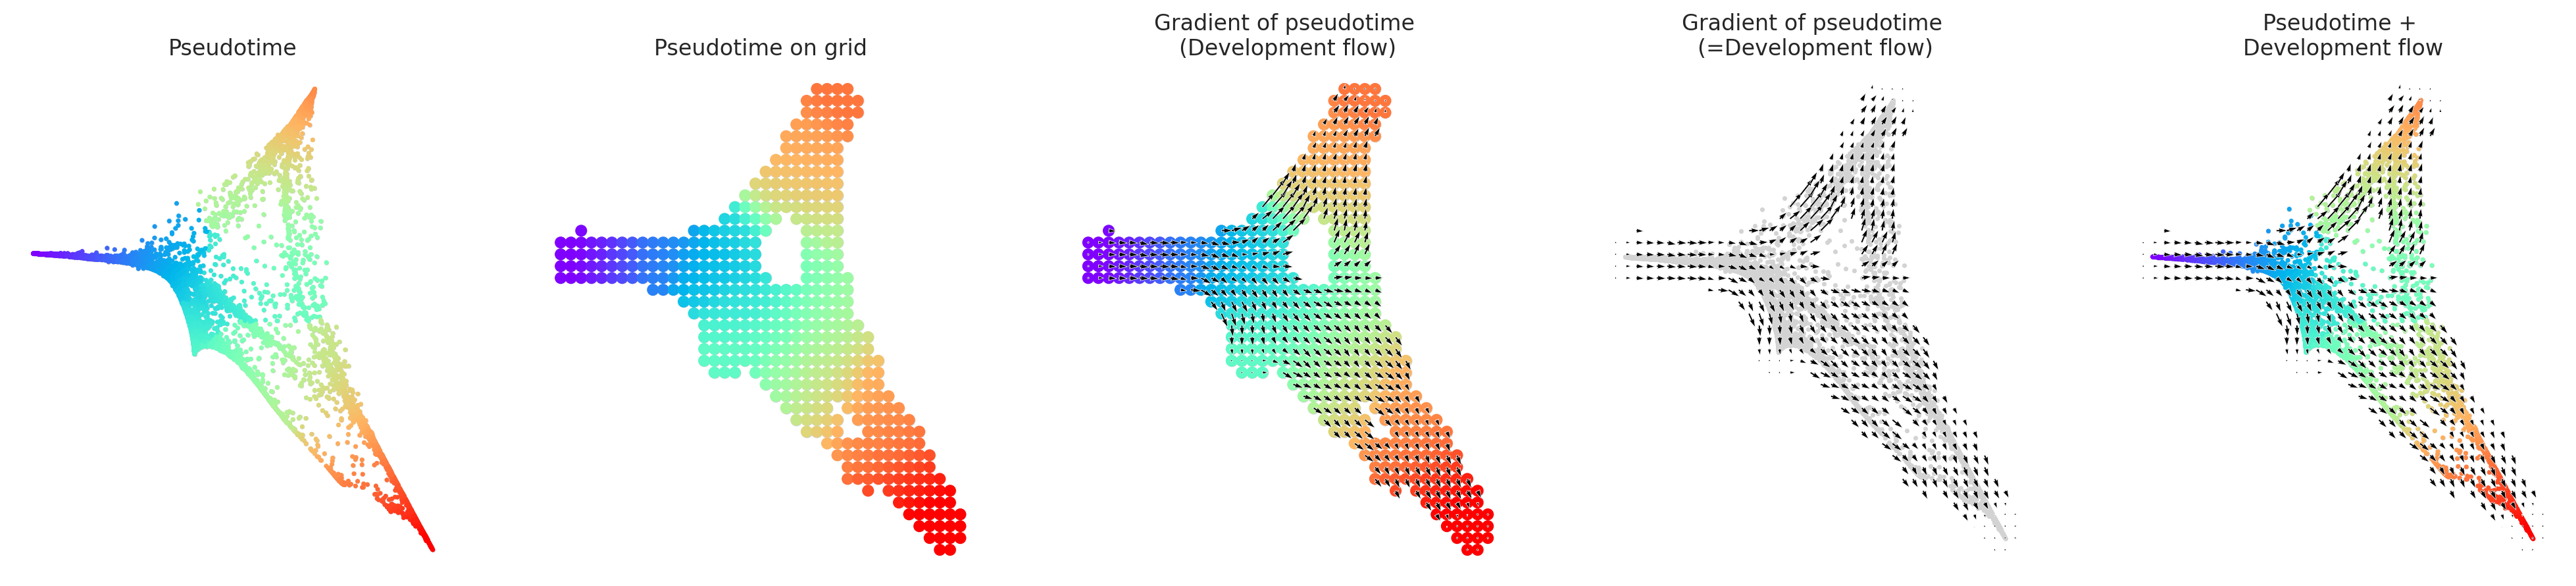

In [8]:
gradient = Gradient_calculator(oracle_object=oracle, pseudotime_key="S2_pseudotime")
gradient.calculate_p_mass(smooth=0.8, n_grid=n_grid, n_neighbors=750)
gradient.calculate_mass_filter(min_mass=min_mass, plot=True)
gradient.transfer_data_into_grid(args={"method": "knn", "n_knn":750}, plot=False)
gradient.calculate_gradient()
scale_dev = 50
gradient.visualize_results(scale=scale_dev, s=5)

In [12]:
cell_idx_pb = np.where((oracle.adata.obs['cell_type_annotation']).isin(['PB_1', 'PB_2', 'early_PB']))[0]
cell_idx_gc = np.where((oracle.adata.obs['cell_type_annotation']).isin(['GC_1', 'GC_2']))[0]
dev = Oracle_development_module()
dev.load_differentiation_reference_data(gradient_object=gradient)
dev.load_perturb_simulation_data(oracle_object=oracle, cell_idx_use=cell_idx_pb, name=f"{goi}_pb")
dev.calculate_inner_product()
dev.calculate_digitized_ip(n_bins=10)
pb_pos_ps = dev.get_sum_of_positive_ips()['score'].sum()
pb_neg_ps = dev.get_sum_of_negative_ips()['score'].sum()
pb_score = abs(pb_pos_ps) +abs(pb_neg_ps)
dev.load_perturb_simulation_data(oracle_object=oracle, cell_idx_use=cell_idx_gc, name=f"{goi}_gc")
dev.calculate_inner_product()
dev.calculate_digitized_ip(n_bins=10)
gc_pos_ps = dev.get_sum_of_positive_ips()['score'].sum()
gc_neg_ps = dev.get_sum_of_negative_ips()['score'].sum()
gc_score = abs(gc_pos_ps) +abs(gc_neg_ps)

{'pb_score': pb_score, 'gc_score': gc_score, 'pb_neg_ps': pb_neg_ps, 'gc_neg_ps': gc_neg_ps, 'pb_pos_ps': pb_pos_ps, 'gc_pos_ps': gc_pos_ps}



In [ ]:
from celloracle.visualizations.config import CONFIG
from celloracle.applications import Oracle_development_module
dev = Oracle_development_module()
dev.load_differentiation_reference_data(gradient_object=gradient)
dev.load_perturb_simulation_data(oracle_object=oracle, cell_idx_use=cell_idx_pb, name=f"{goi}_pb")
dev.calculate_inner_product()
dev.calculate_digitized_ip(n_bins=10)
CONFIG["default_args_quiver"] = {"width": 0.002, "minlength":2, "headwidth":5, "headlength":5, "minshaft":1}
CONFIG["cmap_ps"] = "coolwarm"
CONFIG["default_args"] = {"lw":0.3, "rasterized":False}

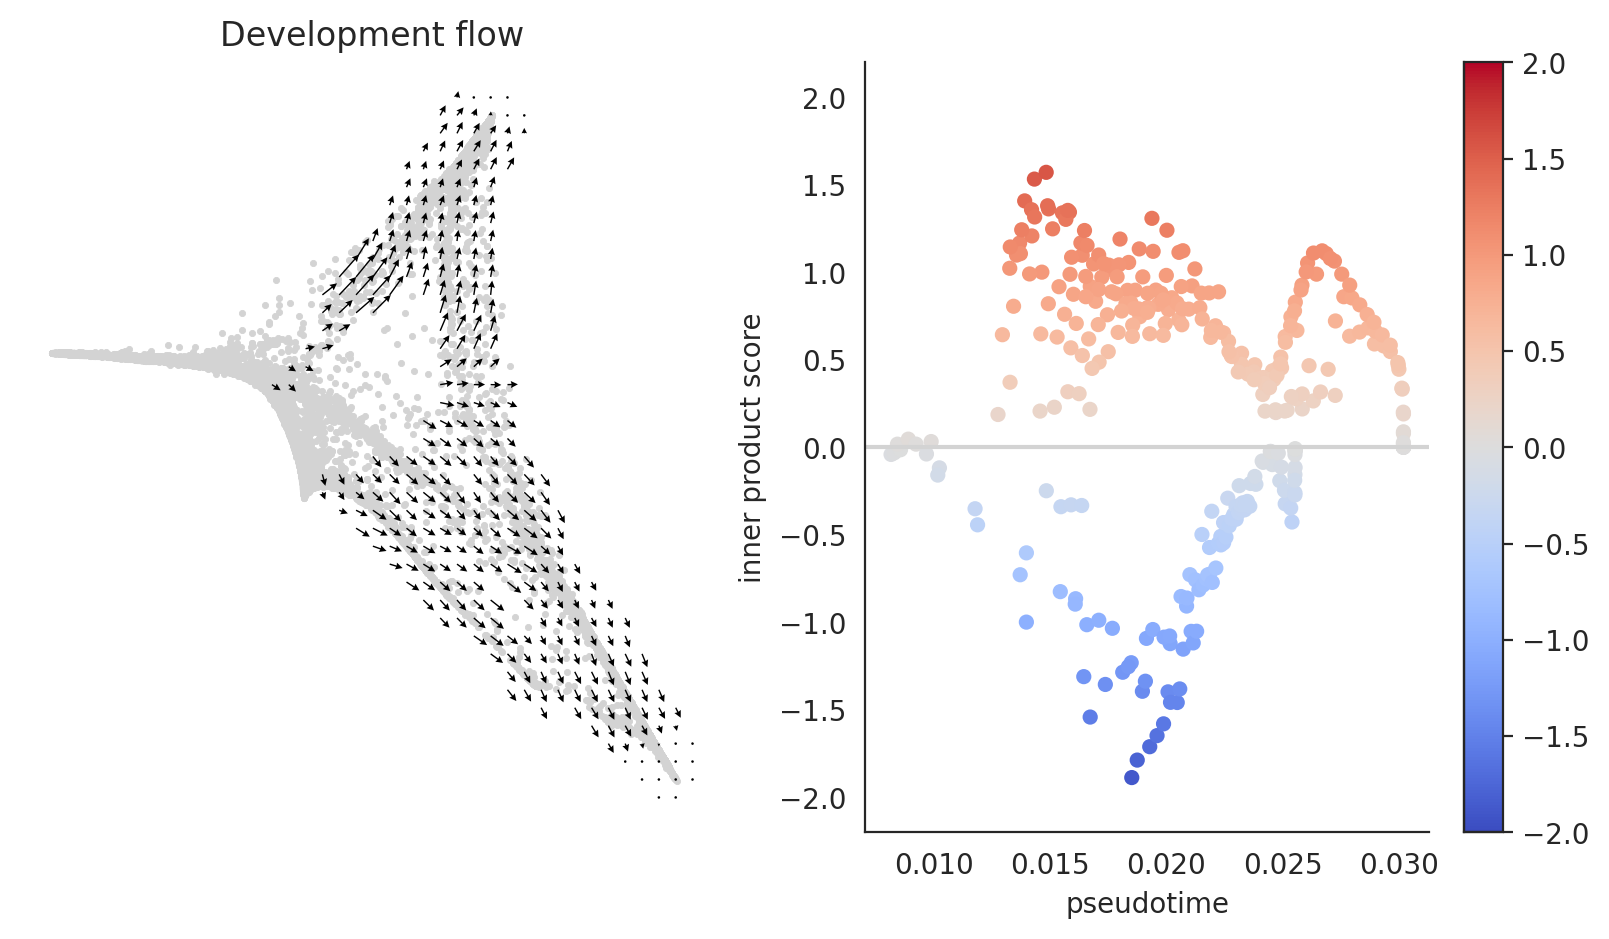

In [49]:
scale_for_pseudotime = 60
show_background = True
s_grid = CONFIG['s_grid']
s = CONFIG['s_scatter']
fig, ax = plt.subplots(1, 2, figsize=[10,5])
ax_ = ax[0]
dev.plot_reference_flow_on_grid(ax=ax_, scale=scale_for_pseudotime, show_background=show_background, s=s, args=CONFIG["default_args_quiver"])
ax_.set_title("Development flow")
ax_ = ax[1]
dev.plot_inner_product_on_pseudotime(ax=ax_, vmin=-2,vmax=2, s=s_grid)
plt.savefig(f"{out_path}/figures/{goi}_development.svg", format='svg')

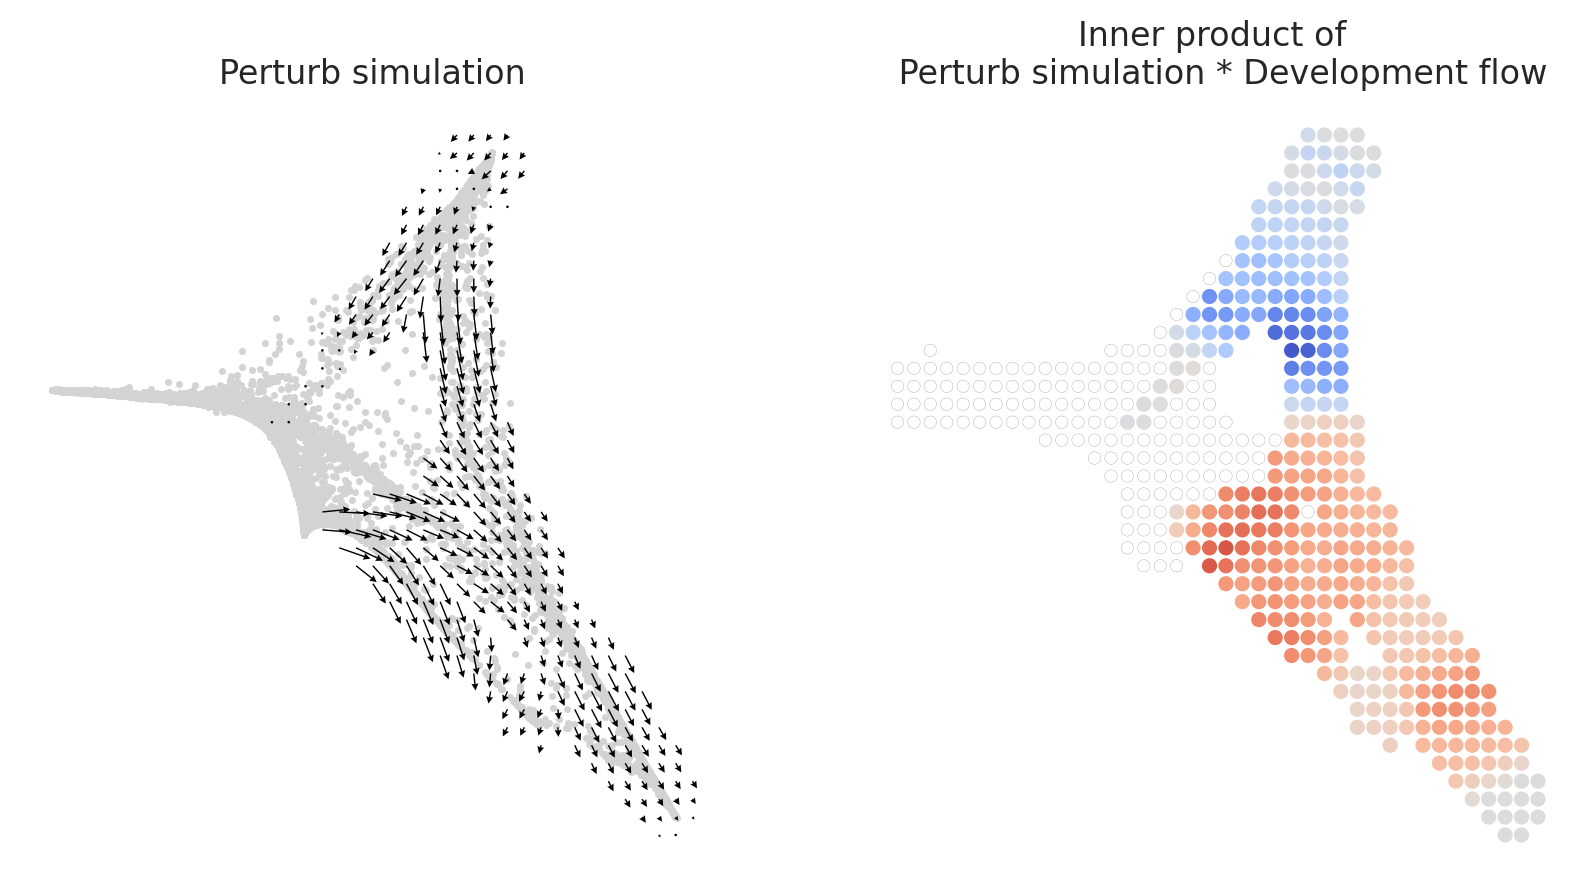

In [50]:
scale_for_simulation = 30
vm=2
fig, ax = plt.subplots(1, 2, figsize=[10, 5])
ax_ = ax[0]
dev.plot_simulation_flow_on_grid(ax=ax_, scale=scale_for_simulation, show_background=show_background, s=s, args=CONFIG["default_args_quiver"])
ax_.set_title("Perturb simulation")

ax_ = ax[1]
dev.plot_inner_product_on_grid(ax=ax_, vm=vm, s=s_grid, show_background=show_background)
ax_.set_title("Inner product of \n Perturb simulation * Development flow")
plt.savefig(f"{out_path}/figures/{goi}_perturbation.svg", format='svg')